In [ ]:
#############################################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
#############################################################################################################
# Evaluate natural speech based survey responses and compare with synthetic ones.
# Evaluated with the survey state on 16/5/2018
#############################################################################################################

import glob
import numpy as np
import matplotlib.pyplot as plt
from evalutils import plot_training_history, statistical_significance
from tabulate import tabulate

model_types = ['MLP', 'LSTM']

scale = np.array([             # 1-5
    'Very inappropriate', 
    'Inappropriate', 
    'Neutral', 
    'Appropriate', 
    'Very appropriate'
])
#######################
# Load groundtruths: <VID, position of models (0=>MLPfirst)>
gt_SI = np.load('./../Dataset/Survey/survey_groundTruths.npz')['SI'] 
gt_SD = np.load('./../Dataset/Survey/survey_groundTruths.npz')['SD'] 

# print gt_SI
# print gt_SD
######################
# Load responses: have to remove first row in Google Sheets, and then download csv!
responses_SI = np.loadtxt('./../Dataset/Survey/Responses/SurveyResponses_NATURAL_SI.csv', dtype='str', skiprows=0, delimiter=',') 
responses_SI = responses_SI[:, 2:] # skip timestamp + agreement
N_resp_SI = responses_SI.shape[0] # number of responses
print "Got ", N_resp_SI, "SI responses.", responses_SI.shape

responses_SD = np.loadtxt('./../Dataset/Survey/Responses/SurveyResponses_NATURAL_SD.csv', dtype='str', skiprows=0, delimiter=',') 
responses_SD = responses_SD[:, 2:] # skip timestamp + agreement
N_resp_SD = responses_SD.shape[0] # number of responses
print "Got ", N_resp_SD, "SD responses.", responses_SD.shape
# print responses

###################################
# Convert labels to numbers 1-5
responses_SI_num = []
for r in responses_SI:
    r_num = []
    for x in r:
        x_num = np.argwhere(scale == x)[0,0] + 1 # 1-5 scale
        r_num.append( x_num )
    responses_SI_num.append( r_num )
responses_SI_num = np.array(responses_SI_num)
print responses_SI_num

responses_SD_num = []
for r in responses_SD:
    r_num = []
    for x in r:
        x_num = np.argwhere(scale == x)[0,0] + 1 # 1-5 scale
        r_num.append( x_num )
    responses_SD_num.append( r_num )
responses_SD_num = np.array(responses_SD_num)
print responses_SD_num

######################################################################
# Check responses: find not reliable respondents
print "SI reliability"
# (1) all left are same
for ii, r in enumerate(responses_SI_num):
    reliable = False
    for i in range(0, 76, 2):
        if i == 0:
            prev = r[i]
        else:
            if prev != r[i]:
                reliable = True
                break
    if not reliable:
        print "Respondent", ii, "not reliable: always same votes for left side"
# (2) all right are same
for ii, r in enumerate(responses_SI_num):
    reliable = False
    for i in range(0, 76, 2):
        if i == 0:
            prev = r[i+1]
        else:
            if prev != r[i+1]:
                reliable = True
                break
    if not reliable:
        print "Respondent", ii, "not reliable: always same votes for right side"
        
print "SD reliability"
# (1) all left are same
for ii, r in enumerate(responses_SD_num):
    reliable = False
    for i in range(0, 76, 2):
        if i == 0:
            prev = r[i]
        else:
            if prev != r[i]:
                reliable = True
                break
    if not reliable:
        print "Respondent", ii, "not reliable: always same votes for left side"
# (2) all right are same
for ii, r in enumerate(responses_SD_num):
    reliable = False
    for i in range(0, 76, 2):
        if i == 0:
            prev = r[i+1]
        else:
            if prev != r[i+1]:
                reliable = True
                break
    if not reliable:
        print "Respondent", ii, "not reliable: always same votes for right side"

######################################################################
# EXCLUDE UNRELIABLE: delete from end

# SD unreliable: index 9
responses_SD_num = np.delete(responses_SD_num, 9, axis = 0)
N_resp_SD = responses_SD_num.shape[0] # number of responses
print "AFTER EXCLUDING: Got ", N_resp_SD, "responses.", responses_SD_num.shape

MAX_N_RESP = 20 # to sync the number of responses between SI and SD, as of 16/5/2018
print "SYNCHRONISED TO ", MAX_N_RESP, "responses."
print "======================================================================================="
print 

responses_SI_num = responses_SI_num[:MAX_N_RESP]
responses_SD_num = responses_SD_num[:MAX_N_RESP]

######################################################################
# Calculate distributions of responses

MLP_SI_mask = []            # determines which questions were about MLP, columns in responses_num
LSTM_SI_mask = []
for gt_i in range(38): # iterate over ground truths
    if gt_SI[gt_i, 1] == '0':                           # MLP was on left:         MLP-LSTM
        MLP_SI_mask.append( 2*gt_i )
        LSTM_SI_mask.append( 2*gt_i + 1 )
    elif gt_SI[gt_i, 1] == '1':                         # LSTM was on left:         LSTM-MLP
        MLP_SI_mask.append( 2*gt_i + 1 )
        LSTM_SI_mask.append( 2*gt_i )
    else:
        raise ValueError('Unknown video position!')
MLP_SI_mask = np.array(MLP_SI_mask)
LSTM_SI_mask = np.array(LSTM_SI_mask)
print MLP_SI_mask
print LSTM_SI_mask
responses_SI_num_MLP = responses_SI_num[:, MLP_SI_mask]
responses_SI_num_LSTM = responses_SI_num[:, LSTM_SI_mask]

MLP_SD_mask = []            # determines which questions were about MLP, columns in responses_num
LSTM_SD_mask = []
for gt_i in range(38): # iterate over ground truths
    if gt_SD[gt_i, 1] == '0':                           # MLP was on left:         MLP-LSTM
        MLP_SD_mask.append( 2*gt_i )
        LSTM_SD_mask.append( 2*gt_i + 1 )
    elif gt_SD[gt_i, 1] == '1':                         # LSTM was on left:         LSTM-MLP
        MLP_SD_mask.append( 2*gt_i + 1 )
        LSTM_SD_mask.append( 2*gt_i )
    else:
        raise ValueError('Unknown video position!')
MLP_SD_mask = np.array(MLP_SD_mask)
LSTM_SD_mask = np.array(LSTM_SD_mask)
print MLP_SD_mask
print LSTM_SD_mask
responses_SD_num_MLP = responses_SD_num[:, MLP_SD_mask]
responses_SD_num_LSTM = responses_SD_num[:, LSTM_SD_mask]

responses_all_num = np.concatenate((responses_SI_num, responses_SD_num), axis=1)

from scipy.io import savemat
savemat('./../Dataset/Survey/NATURAL.mat', 
       {'MLP_SI': responses_SI_num_MLP, 'LSTM_SI': responses_SI_num_LSTM, 
        'MLP_SD': responses_SD_num_MLP, 'LSTM_SD': responses_SD_num_LSTM})

######################################################################
# Overall MLP vs LSTM distribution

dataMLP_SI_NATURAL = responses_SI_num_MLP.flatten().tolist()
dataLSTM_SI_NATURAL = responses_SI_num_LSTM.flatten().tolist()

dataMLP_SD_NATURAL = responses_SD_num_MLP.flatten().tolist()
dataLSTM_SD_NATURAL = responses_SD_num_LSTM.flatten().tolist()


# Save responses for personality investigation
np.savez('./../Dataset/Survey/responses_num.npz', 
         MLP_SI=responses_SI_num_MLP, MLP_SD=responses_SD_num_MLP, 
         LSTM_SI=responses_SI_num_LSTM, LSTM_SD=responses_SD_num_LSTM, 
         gt_SI = gt_SI[:,0], gt_SD = gt_SD[:,0]
        )

MLP vs LSTM
	0.305263157895 1.3998404793e-31
	 samples A and B are significantly different
	0.256578947368 1.95440848957e-22
	 samples A and B are significantly different
SI vs SD
	-4.93080722593 9.09248127332e-07
	 samples A and B are significantly different
	0.360526315789 6.99489508992e-44
	 samples A and B are significantly different


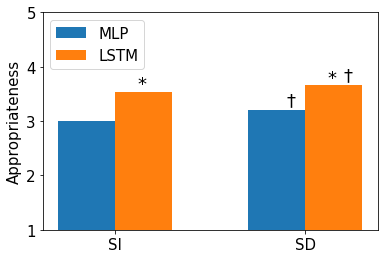

In [2]:
################################################################
# Compare MLP vs LSTM for SI and SD, on natural speech
################################################################
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

xaxis = np.arange(2)
w = 0.3 # bar width
# clrs = ['blue', 'orange']
# plt.figure(figsize=(7,5))
plt.figure()
plt.bar(xaxis-w, [np.mean(dataMLP_SI_NATURAL), np.mean(dataMLP_SD_NATURAL)], 
        #yerr=[np.std(dataMLP_SI_NATURAL), np.std(dataMLP_SD_NATURAL)], 
        width=w, align='edge', label='MLP')#, color=clrs[0])
plt.bar(xaxis,    [np.mean(dataLSTM_SI_NATURAL), np.mean(dataLSTM_SD_NATURAL)], 
        #yerr=[np.std(dataLSTM_SI_NATURAL), np.std(dataLSTM_SD_NATURAL)], 
        width=w, align='edge', label='LSTM')#, color=clrs[1])

ax = plt.gca()
p = ax.patches    
print "MLP vs LSTM"
of = 0.6
i = 0
ss = statistical_significance(dataMLP_SI_NATURAL, dataLSTM_SI_NATURAL, 0.001, False)
if ss: # is stat sig => put asterisk
    ax.text(p[i].get_x()+w/0.72, p[i].get_height() + of, '*', fontsize=18)
i = 1
ss = statistical_significance(dataMLP_SD_NATURAL, dataLSTM_SD_NATURAL, 0.001, False)
if ss: # is stat sig => put asterisk
    ax.text(p[i].get_x()+w/0.72, p[i].get_height() + of-0.1, '*', fontsize=18)

print "SI vs SD"
ss = statistical_significance(dataMLP_SI_NATURAL, dataMLP_SD_NATURAL, 0.001, False)
if ss:
    ax.text(p[i].get_x()+w/0.6, p[i].get_height() + of-0.07, '$\dagger$', fontsize=18)

ss = statistical_significance(dataMLP_SI_NATURAL, dataLSTM_SD_NATURAL, 0.001, False)
if ss:
    ax.text(p[i].get_x()+w/1.5, p[i].get_height() + of -0.54, '$\dagger$', fontsize=18)


plt.xticks(xaxis, ['SI', 'SD'], rotation=0)
yaxis = np.arange(5) + 1
plt.yticks( yaxis, yaxis )
plt.ylim( 1, 5 )
plt.ylabel('Appropriateness')
plt.legend(loc='upper left')
plt.show()

[2.9960526315789475, 3.5087209302325579]
[3.5421052631578949, 3.0276162790697674]
	0.305263157895 1.3998404793e-31
	 samples A and B are significantly different
	0.256578947368 1.95440848957e-22
	 samples A and B are significantly different


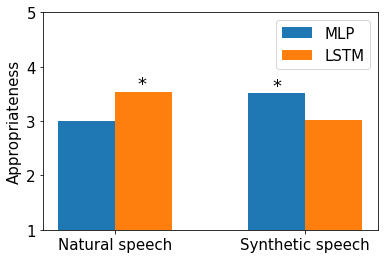

In [3]:
################################################################
# Compare MLP-SI vs LSTM-SI on natural and synthetic speech
################################################################

data_SYNTHETIC = np.load('./../Dataset/Survey/SYNTHETIC_responses_num.npz')
dataMLP_SI_SYNTHETIC = data_SYNTHETIC['dataMLP_SI_SYNTHETIC']
dataLSTM_SI_SYNTHETIC = data_SYNTHETIC['dataLSTM_SI_SYNTHETIC']

print [np.mean(dataMLP_SI_NATURAL), np.mean(dataMLP_SI_SYNTHETIC)]
print [np.mean(dataLSTM_SI_NATURAL), np.mean(dataLSTM_SI_SYNTHETIC)]

xaxis = np.arange(2)
w = 0.3 # bar width
# clrs = ['blue', 'orange']
# plt.figure(figsize=(7,5))
plt.figure()
plt.bar(xaxis-w, [np.mean(dataMLP_SI_NATURAL), np.mean(dataMLP_SI_SYNTHETIC)], 
        #yerr= [np.std(dataMLP_SI_NATURAL), np.std(dataMLP_SI_SYNTHETIC)], 
        width=w, align='edge', label='MLP')#, color=clrs[0])
plt.bar(xaxis,    [np.mean(dataLSTM_SI_NATURAL), np.mean(dataLSTM_SI_SYNTHETIC)], 
        #yerr=  [np.std(dataLSTM_SI_NATURAL), np.std(dataLSTM_SI_SYNTHETIC)], 
        width=w, align='edge', label='LSTM')#, color=clrs[1])

ax = plt.gca()
p = ax.patches    
of = 0.6
i = 0
ss = statistical_significance(dataMLP_SI_NATURAL, dataLSTM_SI_NATURAL, 0.001, False)
if ss: # is stat sig => put asterisk
    ax.text(p[i].get_x()+w/0.72, p[i].get_height() + of, '*', fontsize=18)
i = 1
ss = statistical_significance(dataMLP_SD_NATURAL, dataLSTM_SD_NATURAL, 0.001, False)
if ss: # is stat sig => put asterisk
    ax.text(p[i].get_x()+w/2.4, p[i].get_height() + of -0.55, '*', fontsize=18)
    

plt.xticks(xaxis, ['Natural speech', 'Synthetic speech'], rotation=0)
yaxis = np.arange(5) + 1
plt.yticks( yaxis, yaxis )
plt.ylim( 1, 5 )
plt.ylabel('Appropriateness')
plt.legend()
plt.show()